# Multidimensional analysis allows users to observe data from different viewpoints

<div style="text-align: center;"><img src="https://data.atoti.io/notebooks/multidimension/img/cube-slice-dice.png"></div>

In [1]:
import pandas as pd

import atoti as tt

In [2]:
session = tt.Session()

In [3]:
sales = session.read_csv(
    "s3://data.atoti.io/notebooks/multidimension/sales.csv",
    types={"Unit price": tt.type.DOUBLE},
)
sales.head()

,Sale ID,Date,Shop,Product,Quantity,Unit price
0,S000003722,2021-02-02,shop_2,TAB_1,3,300.0
1,S000001430,2021-01-15,shop_30,BED_27,1,440.0
2,S000003101,2021-01-24,shop_21,TSH_51,2,22.0
3,S000002060,2021-01-15,shop_20,BED_47,2,395.0
4,S000003731,2021-01-24,shop_11,TSH_10,1,24.0


In [4]:
cube = session.create_cube(sales, "sales cube")

# Data are group into two categories - Data dimensions and measurements

In [5]:
cube

<img alt="Multidimensional cube concept" src="https://data.atoti.io/notebooks/multidimension/img/cube-concept.svg" width="400" />

The axes of the cube are called _hierarchies_.

In [6]:
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.

# Capable of integrating multiple data sources 

In [7]:
products = session.read_csv(
    "s3://data.atoti.io/notebooks/multidimension/products.csv", keys=["Product"]
)
products.head()

,Category,Sub category,Size,Purchase price,Color,Brand
Product,,,,,,
TSH_8,Cloth,Tshirt,S,18.0,red,Basic
SHO_18,Cloth,Shoes,10,46.0,red,Over
TSH_28,Cloth,Tshirt,XS,17.0,red,Basic
SHO_38,Cloth,Shoes,9,44.0,red,Over
BED_48,Furniture,Bed,King,375.0,red,Basic


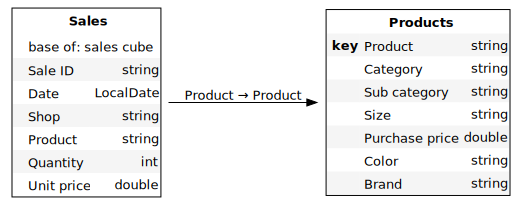

In [8]:
sales.join(products)
session.tables.schema

In [9]:
h, l, m = cube.hierarchies, cube.levels, cube.measures

In [10]:
h

{('Products', 'Brand'): <atoti.hierarchy.Hierarchy object at 0x1330facd0>, ('Sales', 'Sale ID'): <atoti.hierarchy.Hierarchy object at 0x1330fad30>, ('Sales', 'Product'): <atoti.hierarchy.Hierarchy object at 0x1330fae20>, ('Products', 'Sub category'): <atoti.hierarchy.Hierarchy object at 0x1330faf10>, ('Products', 'Category'): <atoti.hierarchy.Hierarchy object at 0x1330fad00>, ('Products', 'Size'): <atoti.hierarchy.Hierarchy object at 0x1330fe130>, ('Sales', 'Date'): <atoti.hierarchy.Hierarchy object at 0x1330fe220>, ('Products', 'Color'): <atoti.hierarchy.Hierarchy object at 0x1330fe310>, ('Sales', 'Shop'): <atoti.hierarchy.Hierarchy object at 0x1330fe400>}

In [11]:
h["Product categories"] = [l["Category"], l["Sub category"]]

In [12]:
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.

# Aggregational flexibility - Pre-processing vs Post-processing



## Pre-processing trades storage consumption for computational efficiency

In [13]:
product_df = pd.read_csv("https://data.atoti.io/notebooks/multidimension/products.csv")
product_df.head()

,Product,Category,Sub category,Size,Purchase price,Color,Brand
0,TAB_0,Furniture,Table,1m80,190.0,black,Basic
1,TAB_1,Furniture,Table,2m40,280.0,white,Mega
2,CHA_2,Furniture,Chair,NaN,48.0,blue,Basic
3,BED_3,Furniture,Bed,Single,127.0,red,Mega
4,BED_4,Furniture,Bed,Double,252.0,brown,Basic


In [14]:
sales_df = pd.read_csv("https://data.atoti.io/notebooks/multidimension/sales.csv")
sales_df.head()

,Sale ID,Date,Shop,Product,Quantity,Unit price
0,S000000029,2021-01-06,shop_29,TSH_29,1,20
1,S000000059,2021-01-06,shop_19,SHO_59,2,60
2,S000000089,2021-01-06,shop_9,TSH_28,4,20
3,S000000119,2021-01-06,shop_39,SHO_58,2,60
4,S000000149,2021-01-06,shop_29,BED_27,2,440


Within the same data source, we can easily perform aggregation by applying the formulas. Notice that our dataset just grew bigger with the additional column?  
By loading this dataset, we traded storage consumption for the computational efficiency because the cube need not compute the sales amount every time we query it.

In [15]:
sales_df["Sales amount"] = sales_df["Quantity"] * sales_df["Unit price"]
sales_df.head()

,Sale ID,Date,Shop,Product,Quantity,Unit price,Sales amount
0,S000000029,2021-01-06,shop_29,TSH_29,1,20,20
1,S000000059,2021-01-06,shop_19,SHO_59,2,60,120
2,S000000089,2021-01-06,shop_9,TSH_28,4,20,80
3,S000000119,2021-01-06,shop_39,SHO_58,2,60,120
4,S000000149,2021-01-06,shop_29,BED_27,2,440,880


When aggregation involves multiple data sources, then we need to handle the joins before we can apply the formulas.

In [16]:
product_sales = pd.merge(sales_df, product_df, on="Product")
product_sales.head()

,Sale ID,Date,Shop,Product,Quantity,Unit price,Sales amount,Category,Sub category,Size,Purchase price,Color,Brand
0,S000000029,2021-01-06,shop_29,TSH_29,1,20,20,Cloth,Tshirt,S,18.0,brown,Mega
1,S000001859,2021-01-06,shop_19,TSH_29,1,20,20,Cloth,Tshirt,S,18.0,brown,Mega
2,S000003689,2021-01-06,shop_9,TSH_29,1,20,20,Cloth,Tshirt,S,18.0,brown,Mega
3,S000001798,2021-01-07,shop_38,TSH_29,3,20,60,Cloth,Tshirt,S,18.0,brown,Mega
4,S000003628,2021-01-07,shop_28,TSH_29,1,20,20,Cloth,Tshirt,S,18.0,brown,Mega


In [17]:
product_sales["Cost price"] = (
    product_sales["Quantity"] * product_sales["Purchase price"]
)
product_sales["Margin"] = sales_df["Sales amount"] - product_sales["Cost price"]
product_sales.head()

,Sale ID,Date,Shop,Product,Quantity,Unit price,Sales amount,Category,Sub category,Size,Purchase price,Color,Brand,Cost price,Margin
0,S000000029,2021-01-06,shop_29,TSH_29,1,20,20,Cloth,Tshirt,S,18.0,brown,Mega,18.0,2.0
1,S000001859,2021-01-06,shop_19,TSH_29,1,20,20,Cloth,Tshirt,S,18.0,brown,Mega,18.0,102.0
2,S000003689,2021-01-06,shop_9,TSH_29,1,20,20,Cloth,Tshirt,S,18.0,brown,Mega,18.0,62.0
3,S000001798,2021-01-07,shop_38,TSH_29,3,20,60,Cloth,Tshirt,S,18.0,brown,Mega,54.0,66.0
4,S000003628,2021-01-07,shop_28,TSH_29,1,20,20,Cloth,Tshirt,S,18.0,brown,Mega,18.0,862.0


Pre-processing works when we are at the most granular level because we will still be able to drill down or roll up.  
At higher aggregation level, we will not know how to break the value when we drill down to the lower level.

<div style="text-align: center;"><img src="https://data.atoti.io/notebooks/multidimension/img/drilldown_rollup.png" width="50%"></div>

## Post-processing computes on the fly and provides flexibility

In [18]:
h, l, m = cube.hierarchies, cube.levels, cube.measures

In [19]:
m["Sales amount"] = tt.agg.sum(
    sales["Quantity"] * sales["Unit price"],
)

In [20]:
m["Cost price"] = tt.agg.sum(
    m["Quantity.SUM"] * tt.agg.single_value(products["Purchase price"]),
    scope=tt.OriginScope(l["Product"]),
)

In [21]:
m["Margin"] = m["Sales amount"] - m["Cost price"]

In [22]:
m["Cumulative amount"] = tt.agg.sum(
    m["Sales amount"], scope=tt.CumulativeScope(level=l["Date"])
)

m["Cumulative margin"] = tt.agg.sum(
    m["Margin"], scope=tt.CumulativeScope(level=l["Date"])
)

In the visualization below, we are missing the sales data for `Shop_0` on 15 Jan 2021. Suppose we use pre-processing computation to get the cumulative values, we will need to perform re-calculation and then reload the data into the cube. With post-processing, this is not required as the data is computed on the fly.

In [23]:
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.

In [24]:
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.

Simply load the missing data into the cube and it will be computed automatically.

In [25]:
sales.load_csv("s3://data.atoti.io/notebooks/multidimension/shop0_20210115.csv")

Re-running the last 2 visualizations should reflect the correct sales.

<div style="text-align:center"><a href="https://www.atoti.io/?utm_source=gallery&utm_content=multidimensional" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Your-turn-to-try-Atoti.jpg" alt="Atoti table" /></a></div>